
# The grid

In [266]:
import matplotlib.pyplot as plt
import numpy as np

X_MIN = 0.0
X_MAX = 10.0
Y_MIN = 0.0
Y_MAX = 10.0
STEP = 0.1
THO = 1
W_MIN = -0.05
W_MAX = 0.05

x_axis = np.arange(X_MIN, X_MAX + STEP, STEP)
x_cells = np.column_stack((x_axis[:-1], x_axis[1:]))

cells = np.array([
    [
        [x_cells[i], x_cells[j]]
        for i in range(len(x_cells))
    ]
    for j in range(len(x_cells))
])

state_intervals = {
    (i, j): cells[j, i]
    for i in range(len(cells))
    for j in range(len(cells))
}

def locate(x,y):
    if (x<0 or x>=10 or y<0 or y>=10): return (-1,-1)
    temp1 = int(x*10)
    temp2 = int(y*10)
    return (temp1, temp2)

# Transition function

In [267]:
inputs = [(i,j) for i in [-0.25, 0.625, 1] for j in [-1, 0, 1]]


def f(x,y,u1,u2,w1,w2):

  Xsucc = x + THO * (u1 + w1)
  Ysucc = y + THO * (u2 + w2)

  return Xsucc, Ysucc

def goTo(i,j, u1, u2):
    xmin = state_intervals[i,j][0,0]
    xmax = state_intervals[i,j][0,1]
    ymin = state_intervals[i,j][1,0]
    ymax = state_intervals[i,j][1,1]

    resXMin, resYMin = f(xmin, ymin, u1, u2, W_MIN, W_MIN)
    resXMax, resYMax = f(xmax, ymax, u1, u2, W_MAX, W_MAX)


    if (resXMin>=10 or resXMax<0) or (resYMin>=10 or resYMax<0):
        return []

    if resXMin < 0: resXMin = 0
    if resXMax >= 10: resXMax = 9.995
    if resYMin < 0: resYMin = 0
    if resYMax >= 10: resYMax = 9.995

    successeur = []
    bornes = [locate(x,y) for x in [resXMin, resXMax] for y in [resYMin, resYMax]]
    for i in range(bornes[0][0], bornes[2][0]+1):
        for j in range(bornes[0][1], bornes[3][1]+1):
            if i<0 or i>=100 or j<0 or j>=100:
                continue
            successeur.append((i,j))
    return successeur


# Specification de surete

In [141]:
def area(Xmin,Xmax,Ymin,Ymax):
  target = []
  bornes = [locate(x,y) for x in [Xmin, Xmax] for y in [Ymin, Ymax]]
  for i in range(bornes[0][0], bornes[2][0]+1):
      for j in range(bornes[0][1], bornes[3][1]+1):
          if i<0 or i>=100 or j<0 or j>=100:
              continue
          target.append((i,j))
  return target


In [142]:
avoid_area = area(3,4,3,4)
avoid_area1 = area(3,4,3,4)
avoid_area2 = area(8,9,7.5,9)
avoid_area3 = area(2,3,8,9)
safe_area = [x for x in state_intervals.keys() if x not in avoid_area]

In [143]:
def Pre(R):
    R1 = set(R)
    predecesseur = []
    for etat in state_intervals.keys():
        for input in inputs:
            temp = goTo(etat[0], etat[1], input[0], input[1])
            flag = 1 if len(temp)!=0 else 0
            for state in temp:
                if state not in R1:
                    flag = 0
                    break
            if flag:
                predecesseur.append(etat)
                break
    return predecesseur

def pointFixe(Q):
    Q1 = set(Q)
    R0 = Q
    prede = Pre(R0)
    R1 = [x for x in prede if x in Q1]
    while R1!=R0:
        R0 = R1
        prede = Pre(R0)
        R1 = [x for x in prede if x in Q1]
    return R1


R_star = pointFixe(safe_area)



# Controlleur symbolique


In [144]:
import random
controlleur_surete = {}
for etat in R_star:
  controlleur_surete[etat] = []
  for input in inputs:
    temp = goTo(etat[0], etat[1], input[0], input[1])
    if temp and all([x in R_star for x in temp]):
      controlleur_surete[etat].append(input)

In [145]:
def move(startState, epoches):
  setOfStates = [startState]
  for i in range(epoches):
    chosenInput = random.choice(controlleur_surete[startState])
    nextState = random.choice(goTo(startState[0], startState[1], chosenInput[0], chosenInput[1]))
    setOfStates.append(nextState)
    startState = nextState
  return setOfStates


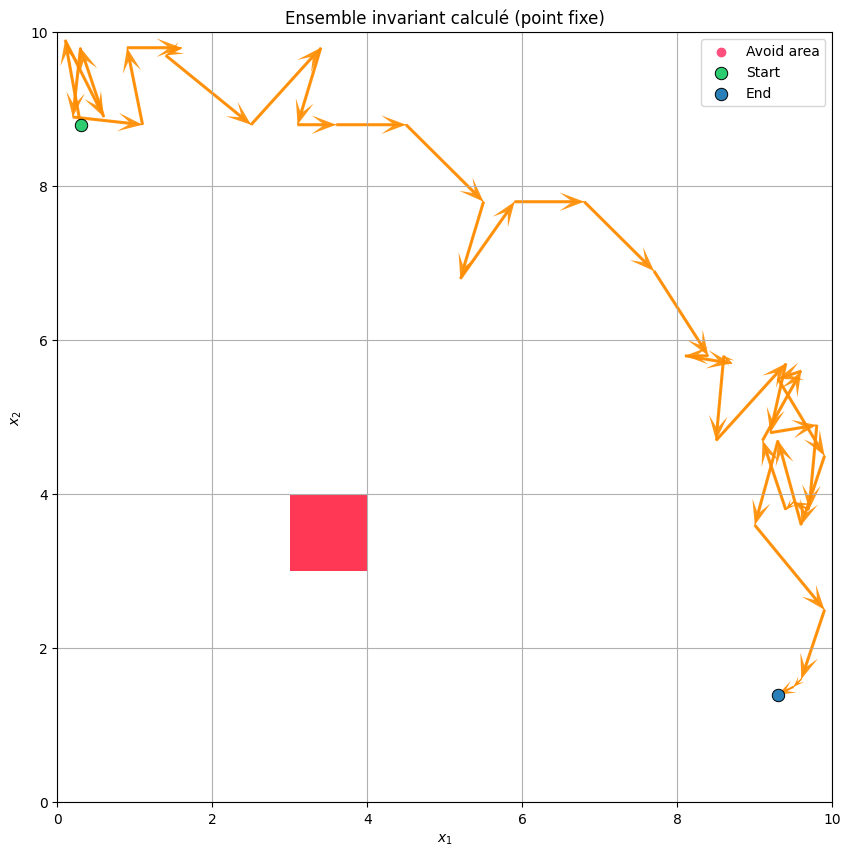

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import random

start = random.choice(list(controlleur_surete.keys()))
trajectoire = move(start, 40)

fig, ax = plt.subplots(figsize=(10, 10))

def plot_area(ax, avoid_area):
    if len(avoid_area) > 0:
        res_arr = np.array(avoid_area)
        x = res_arr[:, 0] / 10
        y = res_arr[:, 1] / 10

        # Zone remplie, couleur forte
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['#ff4f7d'],
            alpha=0.95
        )

        # Halo plus dramatique
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['red'],
            alpha=0.35
        )

        # Contour rouge TRES visible
        ax.tricontour(
            x, y, np.zeros_like(x),
            levels=1,
            colors='red',
            linewidths=3.5
        )


# Dummy scatter for legend
ax.scatter([], [], color='#ff4f7d', label='Avoid area')

# Plot all avoid areas first
plot_area(ax, avoid_area1)

# Then plot trajectory
if len(trajectoire) > 0:
    traj_x = [s[0] / 10 for s in trajectoire]
    traj_y = [s[1] / 10 for s in trajectoire]

    # Thin but visible line
    ax.plot(traj_x, traj_y, color='darkorange', linewidth=0.8, alpha=0.9)

    # Direction arrows with thick heads
    ax.quiver(
        traj_x[:-1], traj_y[:-1],
        np.diff(traj_x), np.diff(traj_y),
        angles='xy', scale_units='xy', scale=1,
        width=0.004,
        headwidth=6,
        headlength=8,
        color='darkorange',
        alpha=0.9
    )

    # Start point
    ax.scatter(traj_x[0], traj_y[0], color='#2ecc71', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='Start')

    # End point
    ax.scatter(traj_x[-1], traj_y[-1], color='#2980b9', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='End')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")


# specification d'atteignabilité

In [147]:
def pointFixeAtteignabilité(Q):
    controlleur_atteint = {}
    R0 = Q
    prede = Pre(R0)
    R1 = set(prede+R0)
    for etat in R1:
      if etat not in Q:
        controlleur_atteint[etat] = []
        for input in inputs:
          successeurs = goTo(etat[0], etat[1], input[0], input[1])
          if successeurs and all([x in R0 for x in successeurs]):
            controlleur_atteint[etat].append(input)
    while R1!=R0:
        R0 = R1
        prede = Pre(R0)
        R1 = set(Q+prede)
        for etat in R1:
          if etat not in Q and etat not in controlleur_atteint.keys():
            controlleur_atteint[etat] = []
            for input in inputs:
              successeurs = goTo(etat[0], etat[1], input[0], input[1])
              if successeurs and all([x in R0 for x in successeurs]):
                controlleur_atteint[etat].append(input)
    return controlleur_atteint

In [148]:
target = area(8,9,8,9)
controlleur_atteint = pointFixeAtteignabilité(target)

In [263]:
trajectoire = []
depart = random.choice(list(controlleur_atteint.keys()))
trajectoire.append(depart)
flag = True
while flag:
  input = random.choice(controlleur_atteint[depart])
  etat = random.choice(goTo(depart[0], depart[1], input[0], input[1]))
  trajectoire.append(etat)
  depart = etat
  if depart in target:
    flag = False

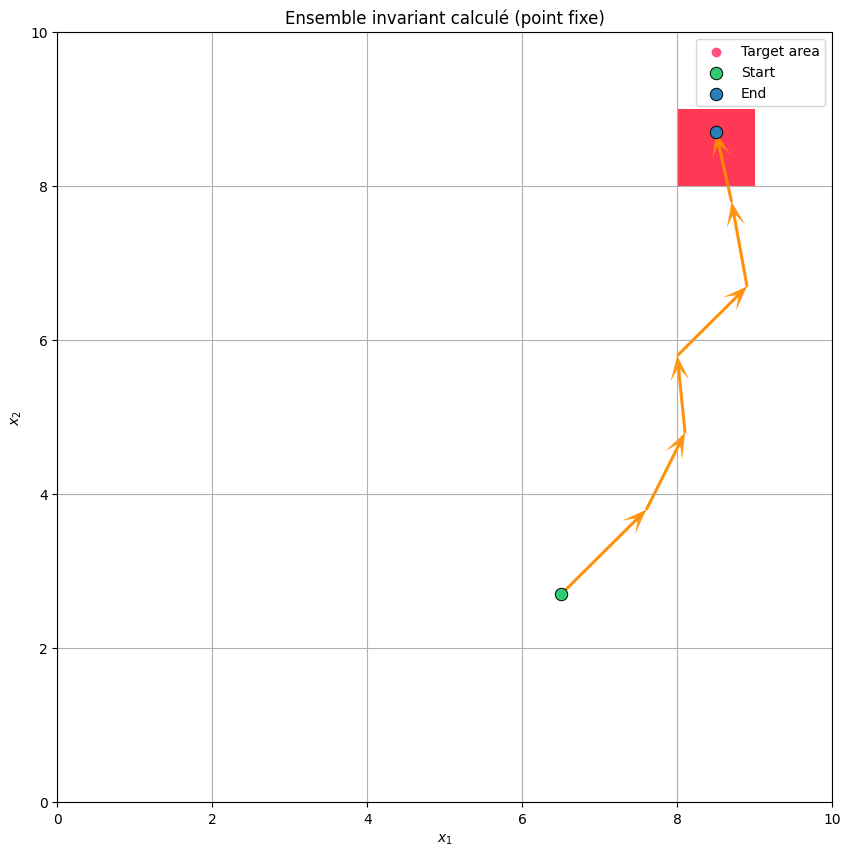

In [264]:
import matplotlib.pyplot as plt
import numpy as np
import random

start = depart


fig, ax = plt.subplots(figsize=(10, 10))

def plot_area(ax, avoid_area):
    if len(avoid_area) > 0:
        res_arr = np.array(avoid_area)
        x = res_arr[:, 0] / 10
        y = res_arr[:, 1] / 10

        # Zone remplie, couleur forte
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['#ff4f7d'],
            alpha=0.95
        )

        # Halo plus dramatique
        ax.tricontourf(
            x, y, np.zeros_like(x),
            levels=1,
            colors=['red'],
            alpha=0.35
        )

        # Contour rouge TRES visible
        ax.tricontour(
            x, y, np.zeros_like(x),
            levels=1,
            colors='red',
            linewidths=3.5
        )


# Dummy scatter for legend
ax.scatter([], [], color='#ff4f7d', label='Target area')

# Plot all avoid areas first
plot_area(ax, target)

# Then plot trajectory
if len(trajectoire) > 0:
    traj_x = [s[0] / 10 for s in trajectoire]
    traj_y = [s[1] / 10 for s in trajectoire]

    # Thin but visible line
    ax.plot(traj_x, traj_y, color='darkorange', linewidth=0.8, alpha=0.9)

    # Direction arrows with thick heads
    ax.quiver(
        traj_x[:-1], traj_y[:-1],
        np.diff(traj_x), np.diff(traj_y),
        angles='xy', scale_units='xy', scale=1,
        width=0.004,
        headwidth=6,
        headlength=8,
        color='darkorange',
        alpha=0.9
    )

    # Start point
    ax.scatter(traj_x[0], traj_y[0], color='#2ecc71', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='Start')

    # End point
    ax.scatter(traj_x[-1], traj_y[-1], color='#2980b9', s=80,
               edgecolor='black', linewidth=0.7, zorder=5, label='End')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)
    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")


# Spécification Dijkstra

🔧 Calcul du contrôleur...
✅ Contrôleur calculé: 10000 états
📋 Exemples d'états dans le contrôleur:
  (90, 88) -> 0 inputs disponibles
  (81, 85) -> 0 inputs disponibles
  (84, 84) -> 0 inputs disponibles
  (87, 80) -> 0 inputs disponibles
  (87, 89) -> 0 inputs disponibles
📊 Graphe construit: 10000 nœuds
🎯 Départ aléatoire choisi: (99, 50)
🎯 Goals disponibles: 121
🔍 Recherche du plus court chemin...


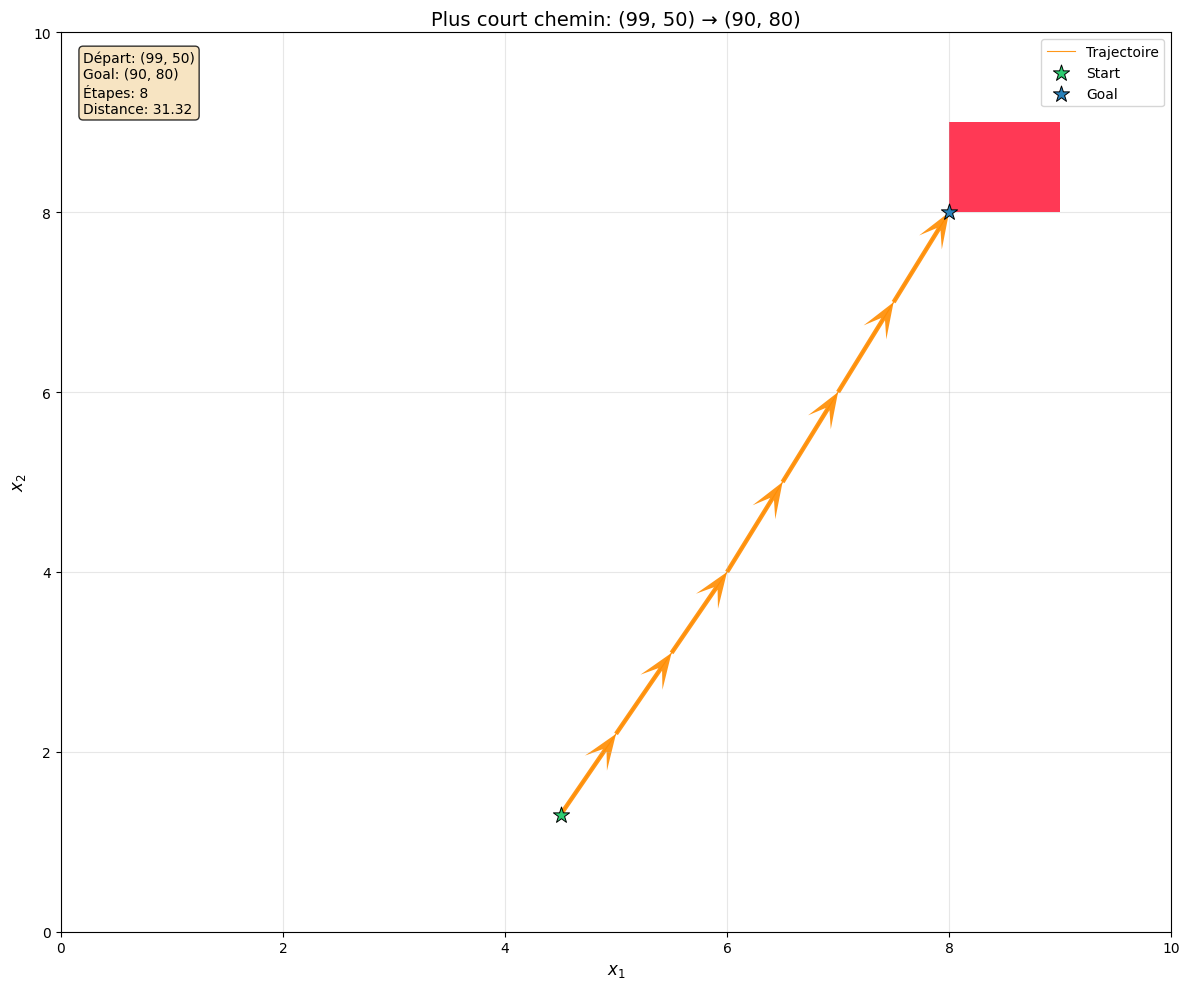

In [151]:
import math
import heapq
import random
import matplotlib.pyplot as plt
import numpy as np

# ================================
# 1) Point fixe atteignabilité - VERSION CORRIGÉE
# ================================
def pointFixeAtteignabilité(Q):
    controlleur_atteint = {}
    R0 = set(Q)  # Convertir en set pour les opérations ensemblistes
    prede = Pre(R0)
    R1 = set(prede) | R0  # Union ensembliste

    # Initialiser les états de Q avec des inputs vides (ce sont des goals)
    for etat in R0:
        controlleur_atteint[etat] = []  # Goals - pas besoin d'inputs

    for etat in R1:
        if etat not in Q:
            controlleur_atteint[etat] = []
            for input in inputs:
                successeurs = goTo(etat[0], etat[1], input[0], input[1])
                if successeurs and all([x in R0 for x in successeurs]):
                    controlleur_atteint[etat].append(input)

    while R1 != R0:
        R0 = R1
        prede = Pre(R0)
        R1 = set(prede) | R0

        for etat in R1:
            if etat not in controlleur_atteint:
                controlleur_atteint[etat] = []
                for input in inputs:
                    successeurs = goTo(etat[0], etat[1], input[0], input[1])
                    if successeurs and all([x in R0 for x in successeurs]):
                        controlleur_atteint[etat].append(input)

    return controlleur_atteint

# ================================
# 2) Construction du graphe
# ================================
def dist(e1, e2):
    return math.sqrt((e1[0]-e2[0])**2 + (e1[1]-e2[1])**2)

def buildGraphFromController(controlleur):
    graph = {etat: [] for etat in controlleur}
    for etat in controlleur:
        for inp in controlleur[etat]:
            succs = goTo(etat[0], etat[1], inp[0], inp[1])
            for succ in succs:
                if succ in controlleur:
                    graph[etat].append((succ, dist(etat, succ), inp))
    return graph

# ================================
# 3) Dijkstra pour le plus court chemin
# ================================
def dijkstraShortestPath(graph, start, goals):
    if not goals:
        return None, {}, {}, {}

    pq = [(0, start)]
    distMap = {s: float('inf') for s in graph}
    distMap[start] = 0
    prev = {s: None for s in graph}
    prev_input = {s: None for s in graph}
    goals_set = set(goals)

    best_goal = None
    best_distance = float('inf')

    while pq:
        d, state = heapq.heappop(pq)

        # Si on trouve un goal, on garde le meilleur
        if state in goals_set:
            if d < best_distance:
                best_goal = state
                best_distance = d
            continue

        if d > distMap[state]:
            continue

        for succ, cost, inp in graph[state]:
            newd = d + cost
            if newd < distMap[succ]:
                distMap[succ] = newd
                prev[succ] = state
                prev_input[succ] = inp
                heapq.heappush(pq, (newd, succ))

    return best_goal, distMap, prev, prev_input

# ================================
# 4) Reconstruction du chemin
# ================================
def reconstructPath(prev, prev_input, start, goal):
    if goal is None:
        return [], []

    path = []
    inputs_seq = []
    node = goal

    while node != start and node is not None:
        path.append(node)
        inputs_seq.append(prev_input[node])
        node = prev[node]

    path.append(start)
    path.reverse()
    inputs_seq.reverse()
    return path, inputs_seq

# ================================
# 5) EXÉCUTION PRINCIPALE - AVEC GESTION D'ERREUR
# ================================

# Étape 1: Calculer le contrôleur
print("🔧 Calcul du contrôleur...")
controlleur = pointFixeAtteignabilité(target)

if not controlleur:
    raise ValueError("Le contrôleur est vide ! Aucun état contrôlable.")

print(f"✅ Contrôleur calculé: {len(controlleur)} états")

# Afficher quelques états du contrôleur
print("📋 Exemples d'états dans le contrôleur:")
for i, etat in enumerate(list(controlleur.keys())[:5]):
    print(f"  {etat} -> {len(controlleur[etat])} inputs disponibles")

# Étape 2: Construire le graphe
graph = buildGraphFromController(controlleur)
print(f"📊 Graphe construit: {len(graph)} nœuds")

# Étape 3: Identifier les états disponibles pour le départ
# Éviter les états qui sont déjà dans target (car ce sont des goals)
etats_depart = [etat for etat in controlleur.keys() if etat not in target]

if not etats_depart:
    print("⚠️  Aucun état de départ disponible hors de target")
    print("🎯 Utilisation de tous les états du contrôleur comme départ possible")
    etats_depart = list(controlleur.keys())

# Choisir un départ aléatoire
start = random.choice(etats_depart)
print(f"🎯 Départ aléatoire choisi: {start}")

# Étape 4: Les goals sont les états dans target qui sont dans le contrôleur
goals = [g for g in target if g in controlleur]
print(f"🎯 Goals disponibles: {len(goals)}")

if not goals:
    print("⚠️  Aucun goal direct dans le contrôleur")
    print("🔍 Recherche d'états les plus proches de target...")

    # Trouver les états du contrôleur les plus proches de target
    distances = []
    for etat in controlleur:
        min_dist_to_avoid = min([dist(etat, g) for g in target])
        distances.append((min_dist_to_avoid, etat))

    # Prendre les 5 états les plus proches comme goals
    distances.sort()
    goals = [etat for _, etat in distances[:5]]
    print(f"🎯 Goals alternatifs choisis (plus proches de target): {len(goals)}")

# Étape 5: Appliquer Dijkstra
print("🔍 Recherche du plus court chemin...")
goal, distMap, prev, prev_input = dijkstraShortestPath(graph, start, goals)

if goal is None:
    print("❌ Aucun chemin trouvé depuis le départ choisi")
    print("🔄 Essai avec un autre départ...")

    # Essayer avec plusieurs départs différents
    for attempt in range(min(5, len(etats_depart))):
        start = random.choice(etats_depart)
        print(f"  Essai {attempt + 1}: départ = {start}")
        goal, distMap, prev, prev_input = dijkstraShortestPath(graph, start, goals)
        if goal is not None:
            print(f"  ✅ Chemin trouvé avec départ: {start}")
            break

    if goal is None:
        raise ValueError("Aucun chemin trouvé après plusieurs tentatives")

# ================================
# 6) VISUALISATION — version STYLE A
# ================================
import numpy as np
import matplotlib.pyplot as plt

def plot_target_area(ax, target_states):
    if len(target_states) == 0:
        return
    res_arr = np.array(target_states)
    x = res_arr[:, 0] / 10
    y = res_arr[:, 1] / 10

    # Strong filled zone
    ax.tricontourf(
        x, y, np.zeros_like(x),
        levels=1,
        colors=['#ff4f7d'],
        alpha=0.95
    )
    # Red halo
    ax.tricontourf(
        x, y, np.zeros_like(x),
        levels=1,
        colors=['red'],
        alpha=0.35
    )
    # Thick red contour
    ax.tricontour(
        x, y, np.zeros_like(x),
        levels=1,
        colors='red',
        linewidths=3.5
    )

# =====================
# CREATE THE FIGURE
# =====================
fig, ax = plt.subplots(figsize=(12, 10))

# ---- 1) Plot TARGET zone (strong, same style as avoid area) ----
plot_target_area(ax, target)

# ---- 2) Plot the computed trajectory ----
if len(path) > 0:
    traj_x = [s[0] / 10 for s in path]
    traj_y = [s[1] / 10 for s in path]

    # Thin, visible orange line
    ax.plot(
        traj_x, traj_y,
        color='darkorange',
        linewidth=0.8,
        alpha=0.9,
        label='Trajectoire'
    )

    # Direction arrows (same style)
    ax.quiver(
        traj_x[:-1], traj_y[:-1],
        np.diff(traj_x), np.diff(traj_y),
        angles='xy', scale_units='xy', scale=1,
        width=0.004,
        headwidth=6,
        headlength=8,
        color='darkorange',
        alpha=0.9
    )

    # Start
    ax.scatter(
        traj_x[0], traj_y[0],
        color='#2ecc71',
        s=150,
        edgecolor='black',
        linewidth=0.7,
        marker='*',
        zorder=5,
        label='Start'
    )

    # Goal
    ax.scatter(
        traj_x[-1], traj_y[-1],
        color='#2980b9',
        s=150,
        edgecolor='black',
        linewidth=0.7,
        marker='*',
        zorder=5,
        label='Goal'
    )
else:
    print("⚠️ Aucune trajectoire à tracer.")

# =====================
# FINAL FIGURE SETTINGS
# =====================
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.set_title(f'Plus court chemin: {start} → {goal}', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Info box
ax.text(
    0.02, 0.98,
    f'Départ: {start}\nGoal: {goal}\nÉtapes: {len(path)}\nDistance: {distMap[goal]:.2f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
)

plt.tight_layout()
plt.show()


# intersection des deux spécifications

In [160]:
controlleur_Suerete_states = {}
for x in controlleur_surete:
  controlleur_Suerete_states[x] = set()
  for input in controlleur_surete[x]:
    temp = goTo(x[0], x[1], input[0], input[1])
    for y in temp:
      controlleur_Suerete_states[x].add(y)
  controlleur_Suerete_states[x] = list(controlleur_Suerete_states[x])

controlleur_Atteint_states = {}
for x in controlleur_atteint:
  controlleur_Atteint_states[x] = set()
  for input in controlleur_atteint[x]:
    temp = goTo(x[0], x[1], input[0], input[1])
    for y in temp:
      controlleur_Atteint_states[x].add(y)
  controlleur_Atteint_states[x] = list(controlleur_Atteint_states[x])


In [161]:
controlleur_intersection = {}

for x in controlleur_Suerete_states:
    if x in controlleur_Atteint_states:
        common = [
            y
            for y in controlleur_Suerete_states[x]
            if y in controlleur_Atteint_states[x]
        ]
        controlleur_intersection[x] = common

while any([not controlleur_intersection[x] for x in controlleur_intersection]):
  for x in list(controlleur_intersection.keys()):
    if not controlleur_intersection[x]:
      trap = x
      del(controlleur_intersection[x])
      for y in controlleur_intersection:
        if trap in controlleur_intersection[y]:
          controlleur_intersection[y].remove(trap)


In [187]:
trajectoire_inter = []
depart = random.choice(list(controlleur_intersection.keys()))
trajectoire_inter.append(depart)
flag = True
while flag:
  etat = random.choice(controlleur_intersection[depart])
  trajectoire_inter.append(etat)
  depart = etat
  if depart in target:
    flag = False

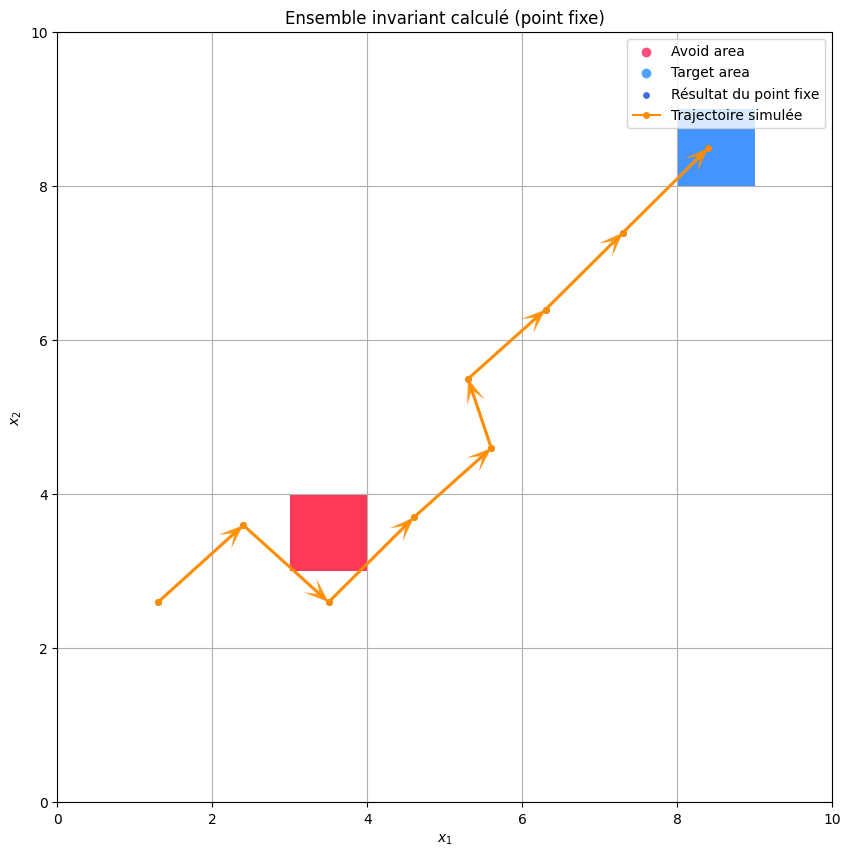

In [188]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))


# =========================================================
# Helper: plot a region with STYLE A (filled + halo + contour)
# =========================================================
def plot_strong_area(ax, area_states, color_fill, color_halo, color_contour, label):
    if len(area_states) == 0:
        return

    res_arr = np.array(area_states)
    x = res_arr[:, 0] / 10
    y = res_arr[:, 1] / 10

    # Strong filled zone
    ax.tricontourf(
        x, y, np.zeros_like(x),
        levels=1,
        colors=[color_fill],
        alpha=0.95
    )

    # Halo
    ax.tricontourf(
        x, y, np.zeros_like(x),
        levels=1,
        colors=[color_halo],
        alpha=0.35
    )

    # Thick contour
    ax.tricontour(
        x, y, np.zeros_like(x),
        levels=1,
        colors=color_contour,
        linewidths=3.5
    )

    # Dummy scatter for legend
    ax.scatter([], [], color=color_fill, label=label)



# =========================================================
# 1) Plot AVOID area (RED)
# =========================================================
plot_strong_area(
    ax,
    avoid_area,
    color_fill='#ff4f7d',     # deep pink fill
    color_halo='red',          # red halo
    color_contour='red',       # red contour
    label='Avoid area'
)


# =========================================================
# 2) Plot TARGET area (BLUE)
# =========================================================
plot_strong_area(
    ax,
    target,
    color_fill='#4fa3ff',      # strong blue fill
    color_halo='#1e6fff',      # blue halo
    color_contour='#1e6fff',   # blue contour
    label='Target area'
)


# =========================================================
# 3) Plot trajectoire_inter
# =========================================================
if len(trajectoire_inter) > 0:

    traj_x = [s[0] / 10 for s in trajectoire_inter]
    traj_y = [s[1] / 10 for s in trajectoire_inter]

    traj_arr = np.array(trajectoire_inter)

    # Blue points (path samples)
    ax.scatter(
        traj_arr[:, 0] / 10,
        traj_arr[:, 1] / 10,
        s=15,
        color='royalblue',
        label='Résultat du point fixe'
    )

    # Orange trajectory line
    ax.plot(
        traj_x, traj_y,
        '-o',
        color='darkorange',
        linewidth=1.5,
        markersize=4,
        label='Trajectoire simulée'
    )

    # Arrows
    if len(traj_x) > 1:
        ax.quiver(
            traj_x[:-1], traj_y[:-1],
            np.diff(traj_x), np.diff(traj_y),
            angles='xy', scale_units='xy', scale=1,
            width=0.004,
            headwidth=6,
            headlength=8,
            color='darkorange',
            alpha=0.9
        )


# =========================================================
# 4) Final styling
# =========================================================
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Ensemble invariant calculé (point fixe)')
ax.legend()
ax.grid(True)

plt.show()


# spécification basée sur les automates

#### fonctions et variables nécessaire au bon déroulet du code :

In [189]:
automate = {
    "a":{0:"a",1:"b",2:"c",3:"a",4:"e"},
    "b":{0:"b",1:"b",2:"e",3:"d",4:"e"},
    "c":{0:"c",1:"e",2:"c",3:"d",4:"e"},
    "d":{0:"d",1:"d",2:"d",3:"d",4:"d"},
    "e":{0:"e",1:"e",2:"e",3:"e",4:"e"}
    }

In [190]:
Q1 = area(4,5,8.5,9.5)
Q2 = area(8.5,9.5,2,3)
Q3 = area(2,3,0.5,1.5)
Q4 = area(3,7,3,7)

setQ1 = set(Q1); setQ2 = set(Q2); setQ3 = set(Q3); setQ4 = set(Q4)

In [191]:
def labelisation(etat):
  if etat in setQ1: return 1
  if etat in setQ2: return 2
  if etat in setQ3: return 3
  if etat in setQ4: return 4
  return 0

def h1(state,etat):
  return automate[state][labelisation(etat)]

In [192]:
space = [(state,etat) for state in ["a","b","c","d","e"] for etat in state_intervals.keys() ]

def g(state,etat,input):
  res = []
  for etat_successeur in goTo(etat[0],etat[1],input[0],input[1]):
    res.append((h1(state,etat_successeur),etat_successeur))
  return res

In [193]:
controlleur_automate = {}
def predecessueur(R):
  predecesseurs = []
  Rset = set(R)
  for state,etat in space:
    if (state,etat) in controlleur_automate:
      continue
    taken = False
    for input in inputs:
      temp = g(state,etat,input)
      if not temp:
        continue
      if all([x in Rset for x in temp]):
        if not taken:
          predecesseurs.append((state,etat))
          controlleur_automate[(state,etat)] = [input]
          taken = True;
        else:
          controlleur_automate[(state,etat)].append(input)

  return predecesseurs

In [194]:
def point_fixe_automate(Q):
  R0 = Q
  prede = predecessueur(R0)
  R1 = prede+R0
  while R1!=R0:
    R0 = R1
    prede = predecessueur(R0)
    R1 = R0+prede
  return R1

R_star_automate = point_fixe_automate([etat for etat in space if etat[0]=="d"])
def h2(state,etat):
  return controlleur_automate[(state,etat)]


In [195]:
possible_starts = [x for x in controlleur_automate.keys() if x[0] == "a"]

#### blueprint du code


In [271]:
etat = random.choice(possible_starts)
trajectoire_automate = [etat[1]]

while etat[0] != "d":
  input = random.choice(h2(etat[0], etat[1]))
  etat = random.choice(g(etat[0],etat[1],input))
  trajectoire_automate.append(etat[1])

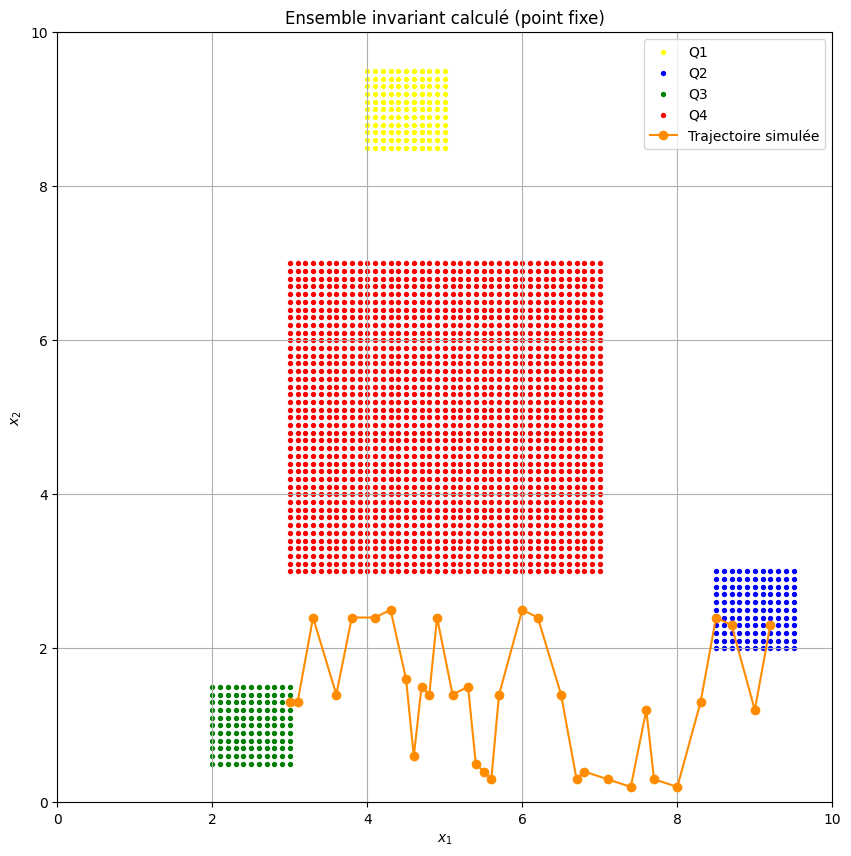

In [272]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

if len(Q1) > 0:
    res_arr = np.array(Q1)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='yellow', label='Q1')

if len(Q2) > 0:
    res_arr = np.array(Q2)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='blue', label='Q2')

if len(Q3) > 0:
    res_arr = np.array(Q3)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='green', label='Q3')

if len(Q4) > 0:
    res_arr = np.array(Q4)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Q4')




# If trajectoire is a list of points [(x1, y1), (x2, y2), ...]
if len(trajectoire_automate) > 0:
    traj_x = [s[0] / 10 for s in trajectoire_automate]
    traj_y = [s[1] / 10 for s in trajectoire_automate]



    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectoire_automate)


    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")

# Nouvelle spécification (basée sur les automates)

In [ ]:
automate_mars = {
    "a": {0:"a", 1:"b", 2:"a", 3:"a", 4:"e", 5:"e"},
    "b": {0:"b", 1:"b", 2:"c", 3:"b", 4:"e", 5:"e"},
    "c": {0:"c", 1:"c", 2:"c", 3:"d", 4:"e", 5:"e"},
    "d": {0:"d", 1:"d", 2:"d", 3:"d", 4:"e", 5:"e"},
    "e": {0:"e", 1:"e", 2:"e", 3:"e", 4:"e", 5:"e"}
}

In [ ]:
Q1 = area(4,5,8.5,9.5)
Q2 = area(8.5,9.5,2,3)
Q3 = area(2,3,0.5,1.5)
Q4 = area(3,5,3,5)
Q5 = area(6,7,5,7)

In [ ]:
def labelisation(etat):
  if etat in Q1: return 1
  if etat in Q2: return 2
  if etat in Q3: return 3
  if etat in Q4: return 4
  if etat in Q5: return 5pdf
  return 0

def h1(state,etat):
  return automate_mars[state][labelisation(etat)]

[(20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (22, 5), (22, 6), (22, 7), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (23, 5), (23, 6), (23, 7), (23, 8), (23, 9), (23, 10), (23, 11), (23, 12), (23, 13), (23, 14), (23, 15), (24, 5), (24, 6), (24, 7), (24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (25, 5), (25, 6), (25, 7), (25, 8), (25, 9), (25, 10), (25, 11), (25, 12), (25, 13), (25, 14), (25, 15), (26, 5), (26, 6), (26, 7), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (27, 5), (27, 6), (27, 7), (27, 8), (27, 9), (27, 10), (27, 11), (27, 12), (27, 13), (27, 14), (27, 15), (28, 5), (28, 6), (28, 7), (28, 8), (28, 9), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (29, 5), (29, 6), (29, 7), (29, 8), (29, 9), (29, 10),

In [ ]:
space = [(state,etat) for state in ["a","b","c","d","e"] for etat in state_intervals.keys()]

def g(state,etat,input):
  res = []
  for etat_successeur in goTo(etat[0],etat[1],input[0],input[1]):
    res.append((h1(state,etat_successeur),etat_successeur))
  return res

[('a', (0, 0)), ('a', (0, 1)), ('a', (0, 2)), ('a', (0, 3)), ('a', (0, 4)), ('a', (0, 5)), ('a', (0, 6)), ('a', (0, 7)), ('a', (0, 8)), ('a', (0, 9)), ('a', (0, 10)), ('a', (0, 11)), ('a', (0, 12)), ('a', (0, 13)), ('a', (0, 14)), ('a', (0, 15)), ('a', (0, 16)), ('a', (0, 17)), ('a', (0, 18)), ('a', (0, 19)), ('a', (0, 20)), ('a', (0, 21)), ('a', (0, 22)), ('a', (0, 23)), ('a', (0, 24)), ('a', (0, 25)), ('a', (0, 26)), ('a', (0, 27)), ('a', (0, 28)), ('a', (0, 29)), ('a', (0, 30)), ('a', (0, 31)), ('a', (0, 32)), ('a', (0, 33)), ('a', (0, 34)), ('a', (0, 35)), ('a', (0, 36)), ('a', (0, 37)), ('a', (0, 38)), ('a', (0, 39)), ('a', (0, 40)), ('a', (0, 41)), ('a', (0, 42)), ('a', (0, 43)), ('a', (0, 44)), ('a', (0, 45)), ('a', (0, 46)), ('a', (0, 47)), ('a', (0, 48)), ('a', (0, 49)), ('a', (0, 50)), ('a', (0, 51)), ('a', (0, 52)), ('a', (0, 53)), ('a', (0, 54)), ('a', (0, 55)), ('a', (0, 56)), ('a', (0, 57)), ('a', (0, 58)), ('a', (0, 59)), ('a', (0, 60)), ('a', (0, 61)), ('a', (0, 62)), (

In [ ]:
controlleur_automate = {}
def predecessueur(R):
  res = []
  Rset = set(R)
  for state,etat in space:
    if (state,etat) in controlleur_automate:
      continue
    taken = False
    for input in inputs:
      temp = g(state,etat,input)
      if not temp:
        continue
      if all([x in Rset for x in temp]):
        if not taken:
          res.append((state,etat))
          controlleur_automate[(state,etat)] = [input]
          taken = True;
        else:
          controlleur_automate[(state,etat)].append(input)

  return res

In [ ]:
def point_fixe_automate(Q):
  R0 = Q
  prede = predecessueur(R0)
  R1 = prede+R0
  while R1!=R0:
    R0 = R1
    prede = predecessueur(R0)
    R1 = R0+prede
  return R1

Q0 = point_fixe_automate([etat for etat in space if etat[0]=="d"])
def h2(state,etat):
  return controlleur_automate[(state,etat)]


[('c', (11, 0)), ('c', (11, 1)), ('c', (11, 2)), ('c', (11, 3)), ('c', (11, 4)), ('c', (11, 6)), ('c', (11, 7)), ('c', (11, 8)), ('c', (11, 9)), ('c', (11, 10)), ('c', (11, 11)), ('c', (11, 12)), ('c', (11, 13)), ('c', (11, 14)), ('c', (11, 16)), ('c', (11, 17)), ('c', (11, 18)), ('c', (11, 19)), ('c', (11, 20)), ('c', (11, 21)), ('c', (11, 22)), ('c', (11, 23)), ('c', (11, 24)), ('c', (12, 0)), ('c', (12, 1)), ('c', (12, 2)), ('c', (12, 3)), ('c', (12, 4)), ('c', (12, 6)), ('c', (12, 7)), ('c', (12, 8)), ('c', (12, 9)), ('c', (12, 10)), ('c', (12, 11)), ('c', (12, 12)), ('c', (12, 13)), ('c', (12, 14)), ('c', (12, 16)), ('c', (12, 17)), ('c', (12, 18)), ('c', (12, 19)), ('c', (12, 20)), ('c', (12, 21)), ('c', (12, 22)), ('c', (12, 23)), ('c', (12, 24)), ('c', (13, 0)), ('c', (13, 1)), ('c', (13, 2)), ('c', (13, 3)), ('c', (13, 4)), ('c', (13, 6)), ('c', (13, 7)), ('c', (13, 8)), ('c', (13, 9)), ('c', (13, 10)), ('c', (13, 11)), ('c', (13, 12)), ('c', (13, 13)), ('c', (13, 14)), ('c', 

In [ ]:
possible_starts = [x for x in controlleur_automate.keys() if x[0] == "a"]

('a', (35, 76))
('a', (35, 77))
('a', (35, 78))
('a', (35, 79))
('a', (35, 80))
('a', (35, 81))
('a', (35, 82))
('a', (35, 83))
('a', (35, 84))
('a', (35, 86))
('a', (35, 87))
('a', (35, 88))
('a', (35, 89))
('a', (35, 90))
('a', (35, 91))
('a', (35, 92))
('a', (35, 93))
('a', (35, 94))
('a', (35, 96))
('a', (35, 97))
('a', (35, 98))
('a', (35, 99))
('a', (36, 76))
('a', (36, 77))
('a', (36, 78))
('a', (36, 79))
('a', (36, 80))
('a', (36, 81))
('a', (36, 82))
('a', (36, 83))
('a', (36, 84))
('a', (36, 86))
('a', (36, 87))
('a', (36, 88))
('a', (36, 89))
('a', (36, 90))
('a', (36, 91))
('a', (36, 92))
('a', (36, 93))
('a', (36, 94))
('a', (36, 96))
('a', (36, 97))
('a', (36, 98))
('a', (36, 99))
('a', (37, 76))
('a', (37, 77))
('a', (37, 78))
('a', (37, 79))
('a', (37, 80))
('a', (37, 81))
('a', (37, 82))
('a', (37, 83))
('a', (37, 84))
('a', (37, 86))
('a', (37, 87))
('a', (37, 88))
('a', (37, 89))
('a', (37, 90))
('a', (37, 91))
('a', (37, 92))
('a', (37, 93))
('a', (37, 94))
('a', (3

In [ ]:
etat = random.choice(possible_starts)
trajectoire_automate = [etat[1]]

while etat[0] != "d":
  input = random.choice(h2(etat[0], etat[1]))
  etat = random.choice(g(etat[0],etat[1],input))
  trajectoire_automate.append(etat[1])

[(99, 80), (96, 81), (95, 71), (94, 71), (91, 81), (90, 80), (88, 70), (87, 81), (85, 80), (84, 70), (81, 60), (80, 51), (77, 41), (75, 41), (74, 42), (71, 41), (69, 32), (67, 31), (65, 40), (64, 39), (61, 30), (59, 40), (56, 49), (54, 49), (52, 59), (51, 69), (48, 79), (46, 88), (57, 79), (64, 79), (75, 69), (84, 58), (95, 47), (94, 46), (93, 36), (90, 26), (87, 36), (84, 37), (81, 36), (78, 25), (76, 16), (73, 6), (70, 6), (67, 7), (64, 18), (63, 19), (60, 8), (58, 7), (56, 16), (54, 25), (53, 34), (50, 24), (48, 15), (47, 15), (44, 6), (41, 16), (38, 7), (36, 18), (35, 27), (33, 28), (31, 17), (29, 7)]


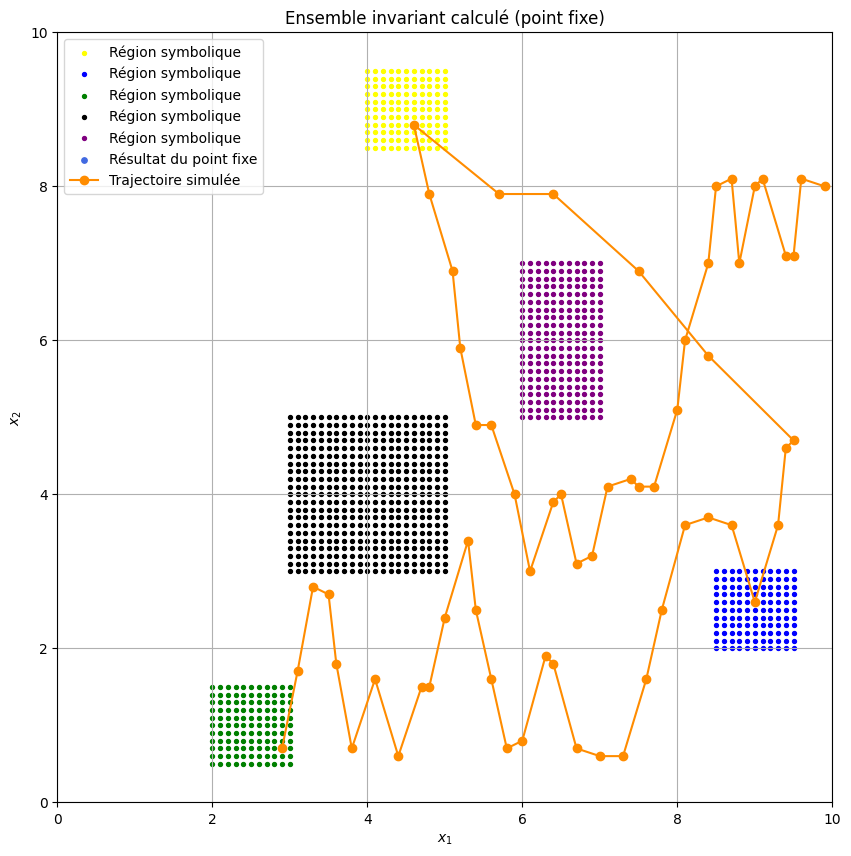

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

if len(Q1) > 0:
    res_arr = np.array(list(Q1))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='yellow', label='Région symbolique')

if len(Q2) > 0:
    res_arr = np.array(list(Q2))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='blue', label='Région symbolique')

if len(Q3) > 0:
    res_arr = np.array(list(Q3))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='green', label='Région symbolique')

if len(Q4) > 0:
    res_arr = np.array(list(Q4))
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='black', label='Région symbolique')

if len(Q5) > 0:
  res_arr = np.array(list(Q5))
  ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='purple', label='Région symbolique')

# if len(Q6) > 0:
#     res_arr = np.array(list(Q6))
#     ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Région symbolique')

# if len(Q7) > 0:
#     res_arr = np.array(list(Q7))
#     ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Région symbolique')


# If trajectoire is a list of points [(x1, y1), (x2, y2), ...]
if len(trajectoire_automate) > 0:
    traj_x = [s[0] / 10 for s in trajectoire_automate]
    traj_y = [s[1] / 10 for s in trajectoire_automate]



    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectoire_automate)
    ax.scatter(traj_arr[:, 0] / 10, traj_arr[:, 1] / 10,
               s=15, color='royalblue', label='Résultat du point fixe')

    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")